1. Using Mean Reversion Idea

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import accuracy_score, brier_score_loss, log_loss

In [3]:
df = pd.read_csv(r"Data\\india_data\\nifty50_data.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df.sort_values("Date", inplace=True)
df.head(5)

,Index Name,Date,PE,PB,Div Yield,Close,Earnings
6513,NIFTY 50,1999-01-01,11.62,2.07,1.83,890.80,76.66
6512,NIFTY 50,1999-01-04,11.72,2.08,1.81,897.80,76.60
6511,NIFTY 50,1999-01-05,11.84,2.11,1.79,907.20,76.62
6510,NIFTY 50,1999-01-06,12.11,2.16,1.75,928.25,76.65
6509,NIFTY 50,1999-01-07,12.46,2.22,1.71,954.70,76.62


Finding out mean of historic index PE

In [4]:
pe_avg = df["PE"].mean()
pe_avg

np.float64(20.872298127110838)

Plotting PE across time

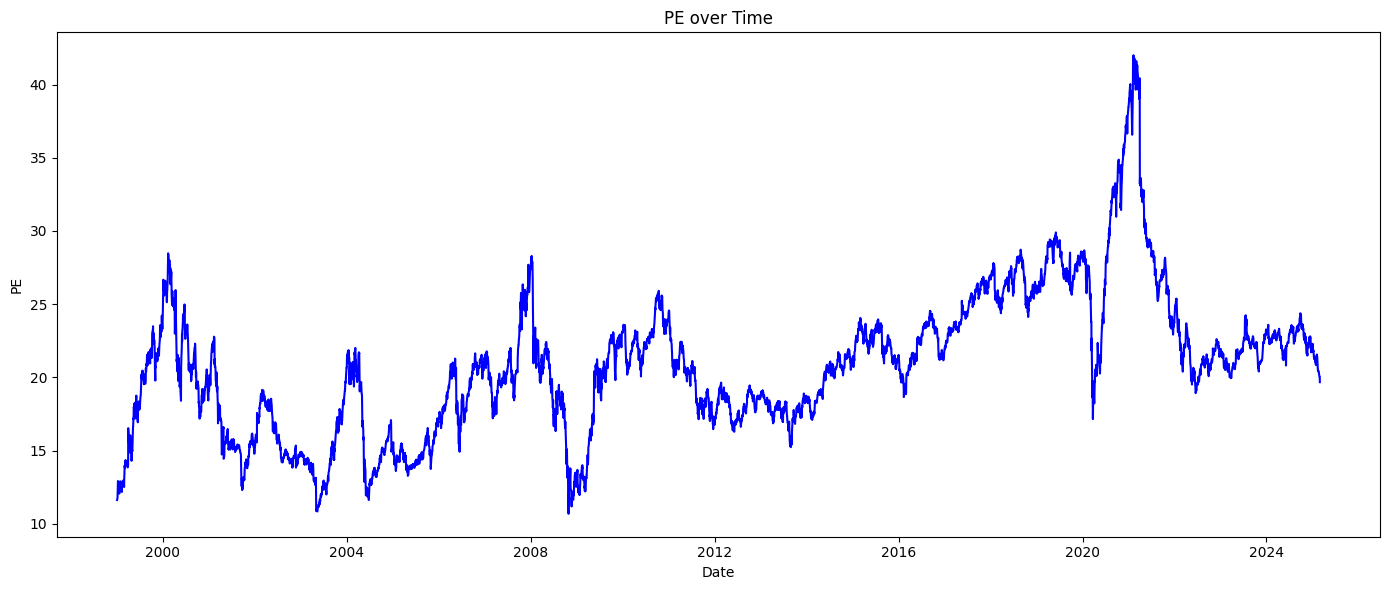

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['PE'], linestyle='-', color='b')

plt.title('PE over Time')
plt.xlabel('Date')
plt.ylabel('PE')

plt.tight_layout()
plt.show()

Outliers might cause mean to increase. Median is less affected by it. Lets use median

In [6]:
pe_median_latest = df['PE'].median()
pe_median_latest

np.float64(20.82)

PE distribution

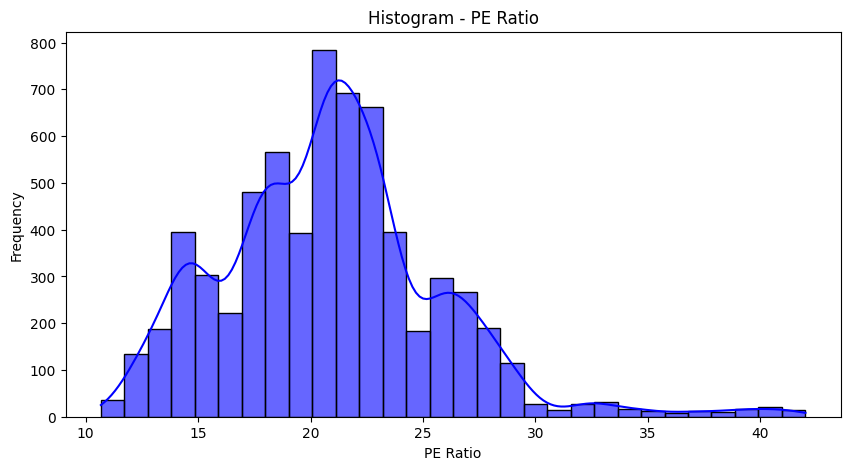

In [7]:
pe_values = df["PE"]
plt.figure(figsize=(10, 5))
sns.histplot(pe_values, bins=30, kde=True, color="blue", alpha=0.6)
plt.title("Histogram - PE Ratio")
plt.xlabel("PE Ratio")
plt.ylabel("Frequency")
plt.show()

We can see that its right-skewed. Its not normally distributed

Plot log(PE)

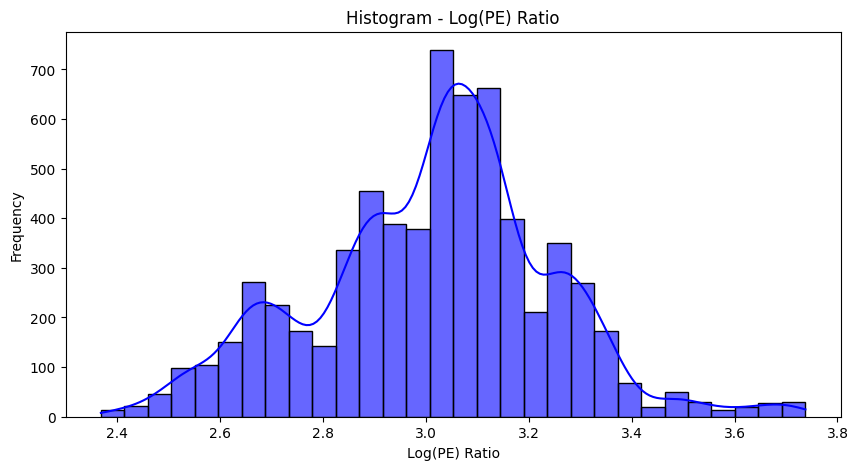

In [8]:
log_pe_values = np.log(pe_values)

plt.figure(figsize=(10, 5))
sns.histplot(log_pe_values, bins=30, kde=True, color="blue", alpha=0.6)
plt.title("Histogram - Log(PE) Ratio")
plt.xlabel("Log(PE) Ratio")
plt.ylabel("Frequency")
plt.show()

Calculate fair value for the Index Price as : Fair Price = (Median PE* Current Earnings)

Calculate the deviation of the actual price from fair value as : Deviation = (Latest Price - Fair Price) / Fair Price * 100 

In [9]:
pe_median = df['PE'].median()
price_fair = pe_median * df["Earnings"].tail(1)[0]
deviation_price = ( df["Close"].tail(1)[0] - price_fair) / price_fair * 100
print(f"Deviation for latest value = {round(deviation_price,2)} %")

Deviation for latest value = -5.52 %


Above fair value for latest earnings. Check this deviation value historically for each day

In [10]:
hist_deviations = []
dates = []
for i in range (len(df)):
    pe_median = df['PE'].median()
    price_fair = pe_median * df["Earnings"].tail(1).iloc[0]
    date = df["Date"].tail(1).iloc[0]
    deviation_price = ( df["Close"].tail(1).iloc[0] - price_fair) / price_fair * 100
    hist_deviations.append(round(deviation_price,2))
    dates.append(date)
    df = df.iloc[:-1]

In [11]:
print(len(hist_deviations))
print(len(dates))
dev_min = min(hist_deviations)
dev_max = max(hist_deviations)
print(dev_min, dev_max)

6514
6514
-39.63 107.41


Plot the deviations to see how they have varied in the past 

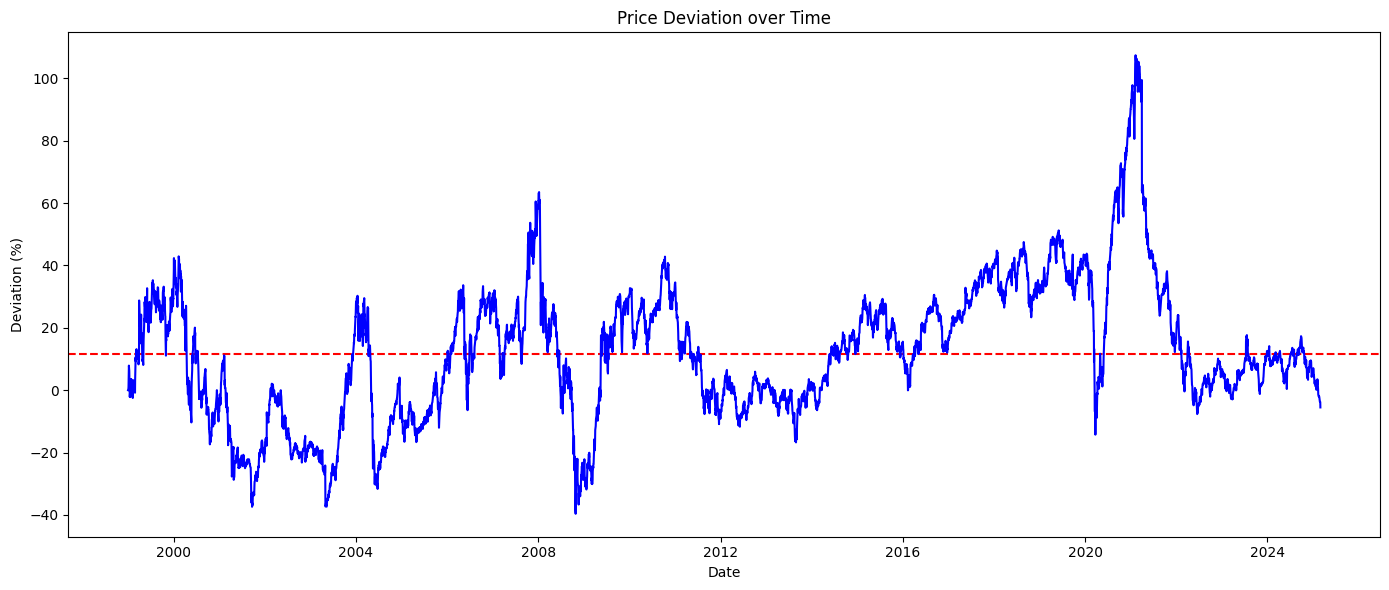

In [12]:
plt.figure(figsize=(14, 6))

median_deviation = np.median(hist_deviations)
plt.axhline(y=median_deviation, color='r', linestyle='--', label=f'Median ({median_deviation:.2f}%)')


plt.plot(dates, hist_deviations,  linestyle='-', color='b')

plt.title('Price Deviation over Time')
plt.xlabel('Date')
plt.ylabel('Deviation (%)')

plt.tight_layout()
plt.show()


In [17]:
pve = 0
nve = 0
for i in hist_deviations:
    if i>0:
        pve += 1 
    else:
        nve += 1
print(pve/len(hist_deviations))

gt25 = 0
lt25 = 0
mid = 0
for i in hist_deviations:
    if i < -0.5:
        lt25+=1
    elif i > 25:
        gt25+=1
    else:
        mid+=1
print(mid/len(hist_deviations), gt25/len(hist_deviations), lt25/len(hist_deviations))

0.7109303039607
0.4435062941357077 0.2789376727049432 0.27755603315934907


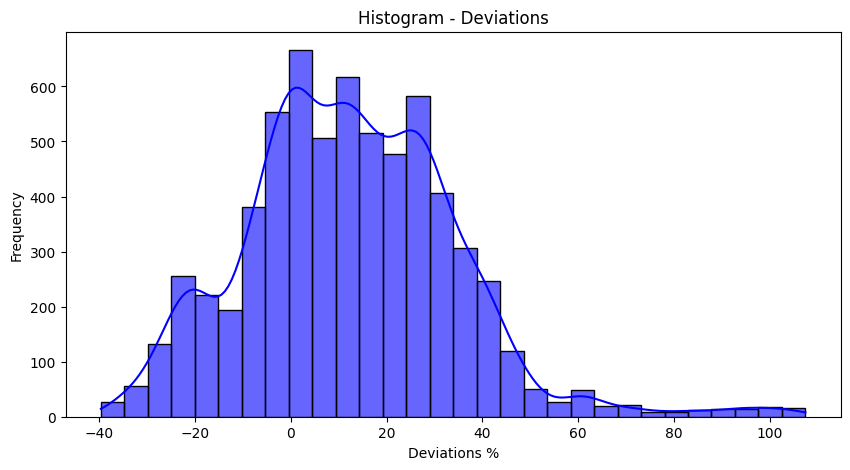

In [86]:
plt.figure(figsize=(10, 5))
sns.histplot(hist_deviations, bins=30, kde=True, color="blue", alpha=0.6)
plt.title("Histogram - Deviations")
plt.xlabel("Deviations %")
plt.ylabel("Frequency")
plt.show()

Skewness & Kurtosis

In [87]:
from scipy.stats import skew, kurtosis

skewness = skew(hist_deviations)
kurt = kurtosis(hist_deviations)

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")

Skewness: 0.6119
Kurtosis: 1.4388


Clearly not normal distribution - right tail is long. Plus fewer outliers than a normal curve. Potential candidate for skew / log-normal

Try skew-normal : https://en.wikipedia.org/wiki/Skew_normal_distribution
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

skewnorm.fit returns 3 parameters as a tuple : a (skewness), loc and scale

these can then be used as input for skewnorm.cdf which takes x, a, loc and scale as parameters

In [88]:
from scipy.stats import skewnorm
parameters = skewnorm.fit(hist_deviations)
print(type(parameters))
a, loc, scale = parameters
print(f"Shape (a): {a}, Location (loc): {loc}, Scale (scale): {scale}")

<class 'tuple'>
Shape (a): 1.7544044520696183, Location (loc): -8.515982953127452, Scale (scale): 30.416233067751


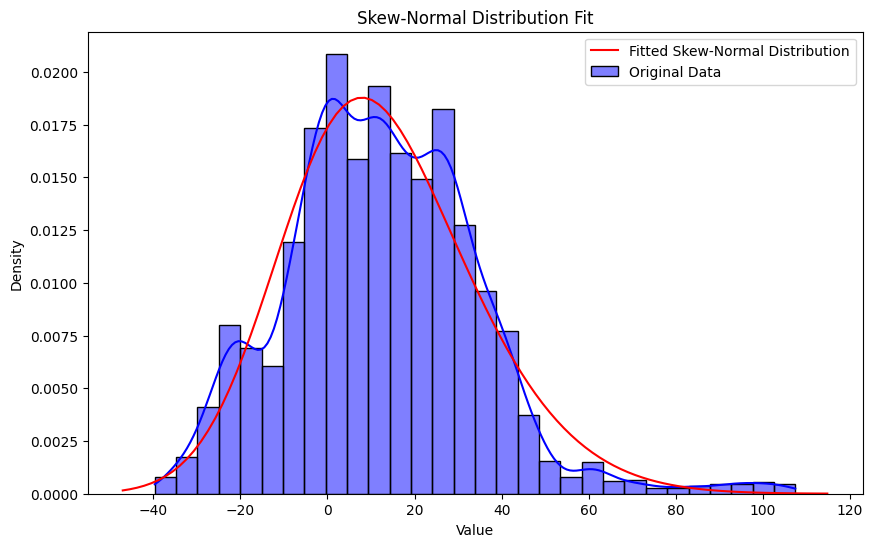

In [89]:
params = skewnorm.fit(hist_deviations)
a, loc, scale = params

plt.figure(figsize=(10, 6))  

sns.histplot(hist_deviations, kde=True, stat="density", color='blue', label='Original Data', bins=30)

xmin, xmax = plt.xlim()  
x = np.linspace(xmin, xmax, 100)
p = skewnorm.pdf(x, a, loc, scale)
plt.plot(x, p, 'r-', label="Fitted Skew-Normal Distribution")

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Skew-Normal Distribution Fit')
plt.legend()

plt.show()

Now it kinda looks like it fits in skew-normal. Though not perfect I think its fine for the trial.

The probability density function (PDF) of a **skew-normal distribution** is :

$$
f(x; \alpha, \mu, \sigma) = \frac{2}{\sigma} \phi \left( \frac{x - \mu}{\sigma} \right) \Phi \left( \alpha \cdot \frac{x - \mu}{\sigma} \right)
$$

Where:

- $ x $ is the variable (deviation).
- $ \mu $ is the mean 
- $ \sigma $ is the standard deviation 
- $ \alpha $ determines the skewness :
    - $ \alpha = 0 $ gives the normal distribution.
    - Positive $ \alpha $ gives right skew.
    - Negative $ \alpha $ gives left skew.
- $ \phi(z) $ is the PDF of the standard normal distribution:
$$
\phi(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2}}
$$
- $ \Phi(z) $ is the cumulative distribution function (CDF) of the standard normal distribution:
$$
\Phi(z) = \int_{-\infty}^{z} \frac{1}{\sqrt{2\pi}} e^{-\frac{t^2}{2}} dt
$$



In [92]:
current_pe = float(input("Enter the current index PE"))
current_price = float(input("Enter the current index level's price"))

current_earnings = current_price / current_pe

price_fair = pe_median_latest*current_earnings
x = float((current_price - price_fair) / price_fair * 100)

cdf = skewnorm.cdf(x, a , loc=loc, scale=scale)

prob_increasing = 1 - cdf

prob_decreasing = cdf

print(f"Fair value is {price_fair :.2f}")
print(f"Deviation from fair value is {x : .2f} %")
print(f"Probability of index increasing: {prob_increasing*100:.2f} %")
print(f"Probability of index decreasing: {prob_decreasing*100:.2f} %")

Fair value is 23424.22
Deviation from fair value is -27.43 %
Probability of index increasing: 97.83 %
Probability of index decreasing: 2.17 %


In [18]:
print(f"{np.mean(hist_deviations): .2f},{np.median(hist_deviations): .2f} " )

 12.47, 11.52 


In [19]:
def calc_prob(x, a, loc, scale, current_price, current_pe, median_pe):

    cdf = skewnorm.cdf(x, a , loc=loc, scale=scale)

    prob_increasing = round((1 - cdf)*100,2)

    prob_decreasing = round(cdf*100,2)
    
    return prob_increasing, prob_decreasing

# Safe to bulk run all cells above this

Lets check backtest historical accuracy of model

In [ ]:
df = pd.read_csv(r"Data\india_data\nifty50_data.csv")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)

initial_days = 1000
forecast_horizon = 126

results = []

for start in range(initial_days, len(df) - forecast_horizon):

    historical_data = df.iloc[:start]

    median_pe = historical_data['PE'].median()

    current_row = df.iloc[start]

    fair_value = median_pe * current_row['Earnings']

    deviation = (current_row['Close'] - fair_value) / fair_value * 100

    historical_deviations = ((historical_data['Close'] - (median_pe * historical_data['Earnings'])) / (median_pe * historical_data['Earnings'])) * 100

    a, loc, scale = skewnorm.fit(historical_deviations)

    cdf = skewnorm.cdf(deviation, a, loc=loc, scale=scale)
    prob_increasing = 1 - cdf
    prob_decreasing = cdf

    prediction = 'Up' if prob_increasing > prob_decreasing else 'Down'
    
    future_close = df.iloc[start + forecast_horizon]['Close']
    actual_movement = 'Up' if future_close > current_row['Close'] else 'Down'
    
    results.append([
        current_row['Date'], prob_increasing, prob_decreasing, prediction, actual_movement
    ])

results_df = pd.DataFrame(results, columns=['Date', 'Prob_Up', 'Prob_Down', 'Prediction', 'Actual'])
results_df.to_csv('binary_results_30.csv', index=False)

print("Backtest complete")

Backtest complete


The results of the backtest

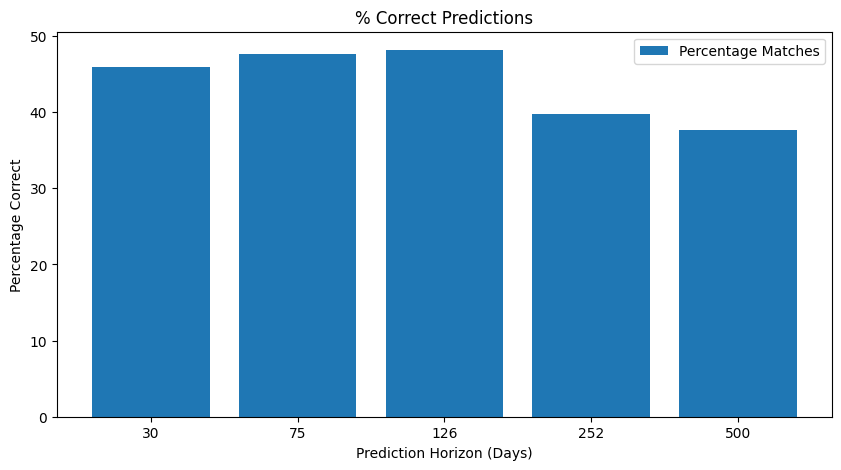

In [39]:
df_30 = pd.read_csv('results_data/binary_results_30.csv')
df_75 = pd.read_csv('results_data/binary_results_75.csv')
df_126 = pd.read_csv('results_data/binary_results_126.csv')
df_252 = pd.read_csv('results_data/binary_results_252.csv')
df_500 = pd.read_csv('results_data/binary_results_500.csv')

def calculate_matches(df):
    return (df['Prediction'] == df['Actual']).sum()

matches_30 = calculate_matches(df_30)
matches_75 = calculate_matches(df_75)
matches_126 = calculate_matches(df_126)
matches_252 = calculate_matches(df_252)
matches_500 = calculate_matches(df_500)

total_30 = len(df_30)
total_75 = len(df_75)
total_126 = len(df_126)
total_252 = len(df_252)
total_500 = len(df_500)

percent_matches_30 = (matches_30 / total_30) * 100
percent_matches_75 = (matches_75 / total_75) * 100
percent_matches_126 = (matches_126 / total_126) * 100
percent_matches_252 = (matches_252 / total_252) * 100
percent_matches_500 = (matches_500 / total_500) * 100

labels = ['30','75', '126', '252', '500']
percent_matches = [percent_matches_30 ,percent_matches_75 ,percent_matches_126, percent_matches_252, percent_matches_500]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, percent_matches, label='Percentage Matches')

ax.set_xlabel('Prediction Horizon (Days)')
ax.set_ylabel('Percentage Correct')
ax.set_title('% Correct Predictions')
ax.legend()

plt.show()

So... its worse than a coinflip at predicting which direction index will take 😂

Uusing median_pe of the past 3 years instead of all time. 

In [23]:
df = pd.read_csv(r"Data\india_data\nifty50_data.csv")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)

initial_days = 1000
forecast_horizon = 126
lookback_years = 5 
trading_days_per_year = 252

results = []

for start in range(initial_days, len(df) - forecast_horizon):
    historical_data = df.iloc[:start]
    
    median_pe = df.iloc[max(0, start - (lookback_years * trading_days_per_year)):start]['PE'].median()
    
    current_row = df.iloc[start]
    
    fair_value = median_pe * current_row['Earnings']
    
    deviation = (current_row['Close'] - fair_value) / fair_value * 100
    
    historical_deviations = ((historical_data['Close'] - (historical_data['PE'].median() * historical_data['Earnings'])) / (historical_data['PE'].median() * historical_data['Earnings'])) * 100
    
    a, loc, scale = skewnorm.fit(historical_deviations)
    
    cdf = skewnorm.cdf(deviation, a, loc=loc, scale=scale)
    prob_increasing = 1 - cdf
    prob_decreasing = cdf
    
    prediction = 'Up' if prob_increasing > prob_decreasing else 'Down'
    
    future_close = df.iloc[start + forecast_horizon]['Close']
    actual_movement = 'Up' if future_close > current_row['Close'] else 'Down'
    
    results.append([
        current_row['Date'], prob_increasing, prob_decreasing, prediction, actual_movement
    ])

results_df = pd.DataFrame(results, columns=['Date', 'Prob_Up', 'Prob_Down', 'Prediction', 'Actual'])
results_df.to_csv('5YmedPE_results_126.csv', index=False)

print("Backtest complete")

Backtest complete


Results of the PE median calculation duration change for the best performing Horizon (126)

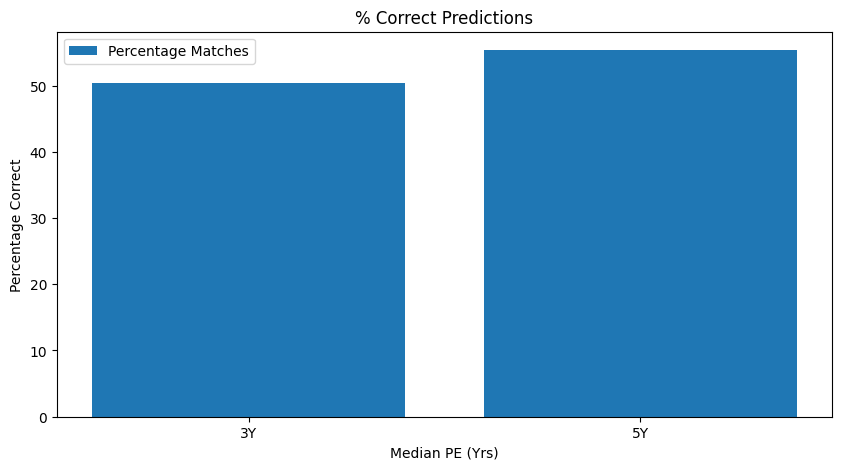

In [24]:
df_3ype = pd.read_csv('3YmedPE_results_126.csv')
df_5ype = pd.read_csv('5YmedPE_results_126.csv')

def calculate_matches(df):
    return (df['Prediction'] == df['Actual']).sum()

matches_3ype = calculate_matches(df_3ype)
matches_5ype = calculate_matches(df_5ype)

total_3ype = len(df_3ype)
total_5ype = len(df_5ype)

percent_matches_3ype = (matches_3ype / total_3ype) * 100
percent_matches_5ype = (matches_5ype / total_5ype) * 100

labels = ['3Y','5Y']
percent_matches = [percent_matches_3ype ,percent_matches_5ype]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, percent_matches, label='Percentage Matches')

ax.set_xlabel('Median PE (Yrs)')
ax.set_ylabel('Percentage Correct')
ax.set_title('% Correct Predictions')
ax.legend()

plt.show()

In [27]:
print(percent_matches_3ype, percent_matches_5ype)

50.352635486265775 55.363771343726796


Not much improvement - still a coinflip 
But this is blind prediction... if the probabilities come out to be say 50.5 and 49.5, then it will predict "Up" though in reality its still quite inconclusive. 

Add a threshold + use 3,5 year recent median PE :

    * If probability  up is > 70% -  predict up 
    * If probability  down is > 70% - predict down
    * Else say, "No trade" 

In [27]:
df = pd.read_csv(r"Data\india_data\nifty50_data.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)

In [56]:
recent_5y_pe = df["PE"].tail(3750)
pe_median_5y = recent_5y_pe.median()
pe_median_5y = 25
pe_median_5y

25

In [57]:
df = pd.read_csv(r"Data\india_data\nifty50_data.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)

initial_days = 1000
forecast_horizon = 126
trading_days_per_year = 252
threshold = 0.70

results = []

for start in range(initial_days, len(df) - forecast_horizon):
    historical_data = df.iloc[:start]
    current_row = df.iloc[start]
    fair_value = pe_median_5y * current_row['Earnings']
    deviation = (current_row['Close'] - fair_value) / fair_value * 100
    historical_deviations = ((historical_data['Close'] - (historical_data['PE'].median() * historical_data['Earnings'])) / (historical_data['PE'].median() * historical_data['Earnings'])) * 100
    a, loc, scale = skewnorm.fit(historical_deviations)
    cdf = skewnorm.cdf(deviation, a, loc=loc, scale=scale)
    prob_increasing = 1 - cdf
    prob_decreasing = cdf
    
    if prob_increasing > threshold:
        prediction = 'Up'
    elif prob_decreasing > threshold:
        prediction = 'Down'
    else:
        continue
    
    future_close = df.iloc[start + forecast_horizon]['Close']
    actual_movement = 'Up' if future_close > current_row['Close'] else 'Down'
    
    results.append([
        current_row['Date'], prob_increasing, prob_decreasing, prediction, actual_movement
    ])

results_df = pd.DataFrame(results, columns=['Date', 'Prob_Up', 'Prob_Down', 'Prediction', 'Actual'])
results_df.to_csv('th_binary_results_fix25pe.csv', index=False)

print("Backtest complete")

Backtest complete


Lets check correct % of this one with threshold + 3 year & 5 year

In [40]:
df_th = pd.read_csv("th_binary_results_3ype.csv")
correct = calculate_matches(df_th)
total = len(df_th)
print(correct / total * 100)

66.23122142390594


3 year one is about 66.23% correct which is better but still not great or "reliable"

In [ ]:
df_th = pd.read_csv("th_binary_results_5ype.csv")
correct = calculate_matches(df_th)
total = len(df_th)
print(correct / total * 100)

68.25595984943538


So using past 5 yr pe has improved to 68.25%...how about 10 year median pe? 

In [47]:
df_th = pd.read_csv("th_binary_results_10ype.csv")
correct = calculate_matches(df_th)
total = len(df_th)
print(correct / total * 100)

71.19904790241


It just keeps increasing in accuracy 🤔. 

For recent 3 yrs : median PE is 21.88, for 5 yrs its 22.68, for 10 yrs its 23.49.... for 15 yrs, it drops to 22.39 

Just set median PE to 25 and check accuracy

In [58]:
df_th = pd.read_csv("th_binary_results_fix25pe.csv")
correct = calculate_matches(df_th)
total = len(df_th)
print(correct / total * 100)

73.13473626673954


In [60]:
actual = df_th["Actual"]
x = len(actual)
y = 0
for i in actual:
    if i == "Up":
        y+=1
print(y/x*100)

79.28395736540038


In general, in these cases of extreme (Up/down) probability > 75%, the index has increased ~80% of the time...  

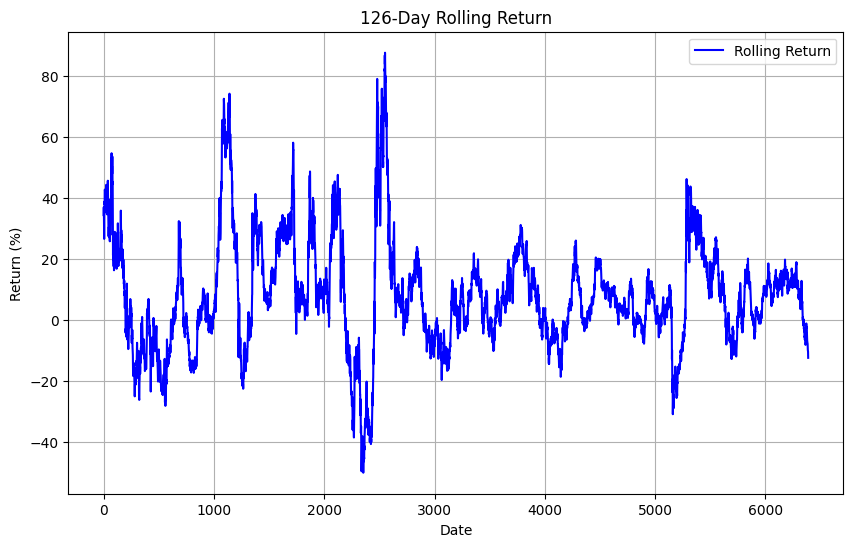

In [ ]:
df = pd.read_csv(r"Data\india_data\nifty50_data.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date').reset_index(drop=True)


rolling_returns = []

for i in range(len(df) - 126):
    initial_close = df['Close'].iloc[i]
    final_close = df['Close'].iloc[i + 126]

    return_value = ((final_close - initial_close) / initial_close) * 100
    rolling_returns.append(return_value)

rolling_returns_df = pd.DataFrame(rolling_returns, index=df.index[:len(rolling_returns)], columns=['Rolling Return'])

plt.figure(figsize=(10, 6))
plt.plot(rolling_returns_df.index, rolling_returns_df['Rolling Return'], label='Rolling Return', color='b')
plt.title('126-Day Rolling Return')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.show()


In [72]:
len(df)

6514

In [71]:
positive_returns = rolling_returns_df[rolling_returns_df['Rolling Return'] > 0]
percentage_positive = (len(positive_returns) / len(rolling_returns_df)) * 100
print(f" {percentage_positive:.2f}%")

 68.61%


Close values vs Fair value plot

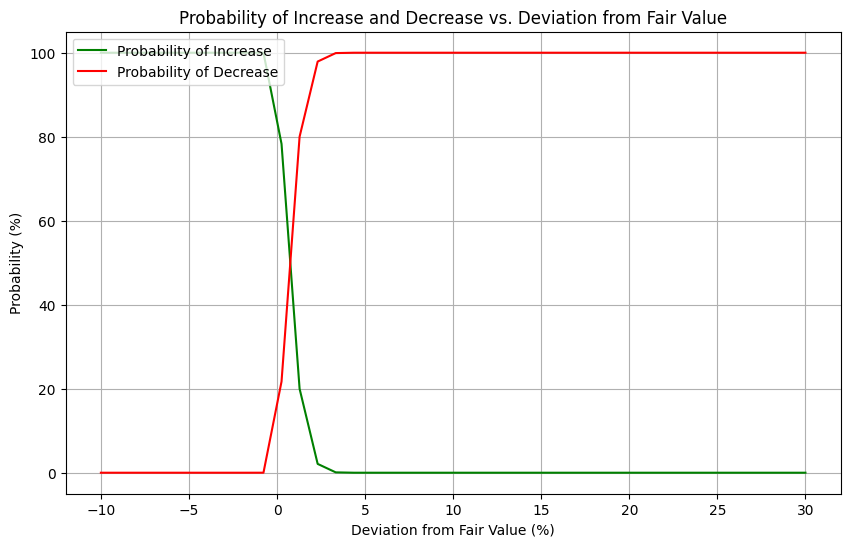

In [106]:
a = 4
loc = 0
scale = 1
pe_median_latest = 15

current_pe = 20.0
current_price = 1000.0

current_earnings = current_price / current_pe
price_fair = pe_median_latest * current_earnings

x_values = np.linspace(-10, 30, 40)

cdf_values = skewnorm.cdf(x_values, a, loc=loc, scale=scale)

prob_increasing_values = 1 - cdf_values
prob_decreasing_values = cdf_values

plt.figure(figsize=(10, 6))
plt.plot(x_values, prob_increasing_values * 100, label='Probability of Increase', color='g')
plt.plot(x_values, prob_decreasing_values * 100, label='Probability of Decrease', color='r')

plt.title('Probability of Increase and Decrease vs. Deviation from Fair Value')
plt.xlabel('Deviation from Fair Value (%)')
plt.ylabel('Probability (%)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()